In [1]:


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import random
import pandas as pd
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [2]:
df = pd.read_csv('automobile_stocks.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2022-10-26,219.399994,230.600006,218.199997,224.639999,224.639999,85012500,TSLA
1,2022-10-27,229.770004,233.809998,222.850006,225.089996,225.089996,61638800,TSLA
2,2022-10-28,225.399994,228.860001,216.350006,228.520004,228.520004,69152400,TSLA
3,2022-10-31,226.190002,229.850006,221.940002,227.539993,227.539993,61554300,TSLA
4,2022-11-01,234.050003,237.399994,227.279999,227.820007,227.820007,62688800,TSLA


In [4]:
df['Stock Name'].unique()

array(['TSLA', 'MSFT', 'NFLX', 'F', 'NIO', 'XPEV'], dtype=object)

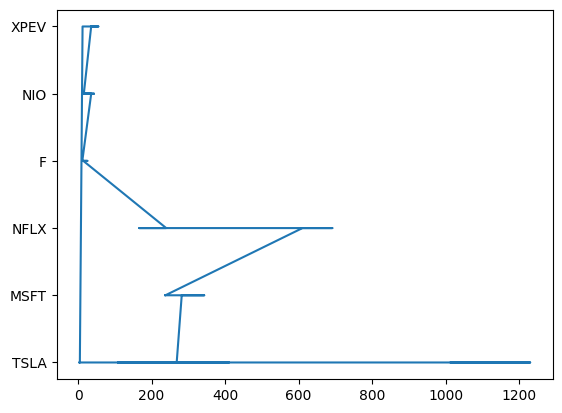

In [5]:
plt.plot(df['Close'],df['Stock Name'])

In [12]:
ano_df = pd.DataFrame(df[['Date','Close','Stock Name']])

In [32]:
ano_df.value_counts()

Date        Close     
2023-10-25  212.419998    2
2010-06-29  4.778000      1
2021-12-02  329.489990    1
2021-12-03  323.010010    1
            43.799999     1
                         ..
2016-09-27  41.161999     1
2016-09-26  41.798000     1
2016-09-23  41.490002     1
2016-09-22  41.285999     1
2023-10-27  207.300003    1
Name: count, Length: 4722, dtype: int64

In [13]:
ano_df

,Date,Close,Stock Name
0,2022-10-26,224.639999,TSLA
1,2022-10-27,225.089996,TSLA
2,2022-10-28,228.520004,TSLA
3,2022-10-31,227.539993,TSLA
4,2022-11-01,227.820007,TSLA
...,...,...,...
4718,2022-03-18,905.390015,TSLA
4719,2022-03-21,921.159973,TSLA
4720,2022-03-22,993.979980,TSLA
4721,2022-03-23,999.109985,TSLA


In [27]:
ano_df.shape

(4723, 2)

In [14]:
ano_df.set_index('Stock Name',inplace=True)
ano_df.head()

,Date,Close
Stock Name,,
TSLA,2022-10-26,224.639999
TSLA,2022-10-27,225.089996
TSLA,2022-10-28,228.520004
TSLA,2022-10-31,227.539993
TSLA,2022-11-01,227.820007


In [19]:
ano_df['Date'] = pd.to_datetime(ano_df['Date'])

In [29]:
ano_df.shape

(4723, 2)

In [15]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(30, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [16]:
autoencoder.compile(optimizer='adam', loss='mae')

In [17]:
def normalize_window_roll(data, window_size):
    X = []
    Y = []
    for i in range(0,len(data) - window_size,5):
        x_window = data.iloc[i:i+window_size]
        
        # Normalize the x_window and y_window
        scaler = MinMaxScaler()
        x_window = scaler.fit_transform(np.array(x_window).reshape(-1, 1))
        
        X.append(x_window)
    X =np.squeeze(np.array(X), axis=2)

    return X

In [21]:
X= normalize_window_roll(ano_df['Close'],30)

In [28]:
X.shape

(939, 30)

In [22]:
train_size = int(0.7*X.shape[0])
test_size = int(0.1*X.shape[0])
val_size = int(0.2*X.shape[0])

X_train = X[:train_size]
X_test = X[train_size:train_size+test_size]
X_val = X[train_size+test_size:train_size+test_size+val_size]

In [26]:

X_train.shape,X_test.shape,X_val.shape

((657, 30), (93, 30), (187, 30))

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(X_train,X_train, epochs=40,
                    validation_data=(X_val, X_val),
                    batch_size=16,
                    callbacks=[early_stopping])

Epoch 1/40
42/42 [==============================] - 1s 8ms/step - loss: 0.2498 - val_loss: 0.2418
Epoch 2/40
42/42 [==============================] - 0s 3ms/step - loss: 0.2353 - val_loss: 0.2199
Epoch 3/40
42/42 [==============================] - 0s 3ms/step - loss: 0.2107 - val_loss: 0.1869
Epoch 4/40
42/42 [==============================] - 0s 3ms/step - loss: 0.1849 - val_loss: 0.1653
Epoch 5/40
42/42 [==============================] - 0s 5ms/step - loss: 0.1674 - val_loss: 0.1521
Epoch 6/40
42/42 [==============================] - 0s 4ms/step - loss: 0.1562 - val_loss: 0.1415
Epoch 7/40
42/42 [==============================] - 0s 4ms/step - loss: 0.1494 - val_loss: 0.1371
Epoch 8/40
42/42 [==============================] - 0s 5ms/step - loss: 0.1458 - val_loss: 0.1345
Epoch 9/40
42/42 [==============================] - 0s 3ms/step - loss: 0.1436 - val_loss: 0.1331
Epoch 10/40
42/42 [==============================] - 0s 3ms/step - loss: 0.1421 - val_loss: 0.1319
Epoch 11/40
42/42 [

21/21 [==============================] - 0s 1ms/step


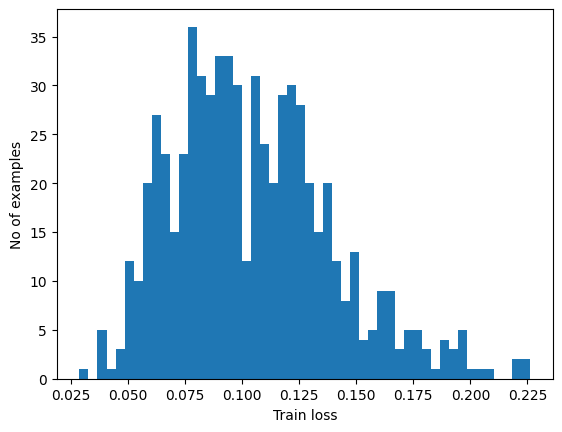

In [33]:
reconstructions = autoencoder.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions, X_train)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [34]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.13978297650164884


3/3 [==============================] - 0s 2ms/step


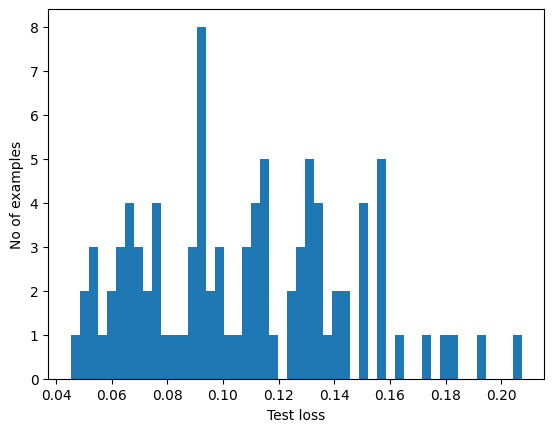

In [35]:
reconstructions = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstructions, X_test)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [36]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)


In [37]:
preds = predict(autoencoder, X_test, threshold)

In [38]:
anomalous_test_data = X_test[np.where(preds==False)]

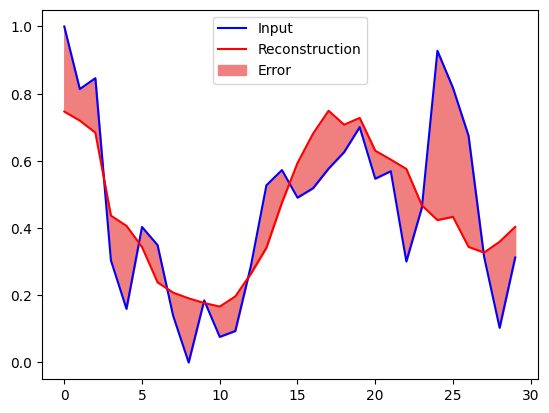

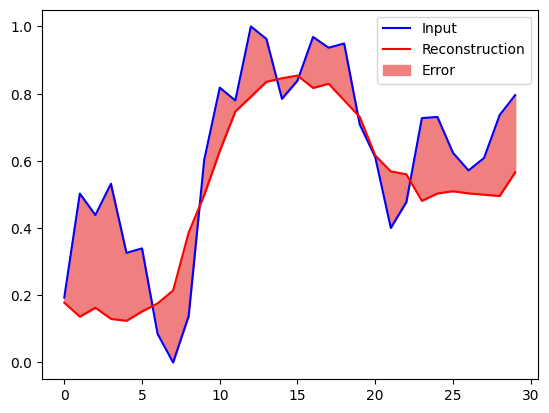

In [42]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()
 
for p in [1,10]:
  plt.plot(anomalous_test_data[p], 'b')
  plt.plot(np.arange(0,X.shape[1]),decoded_data[p], 'r')
  plt.fill_between(np.arange(X.shape[1]), decoded_data[p], anomalous_test_data[p], color='lightcoral')
  plt.legend(labels=["Input", "Reconstruction", "Error"])
  plt.show()